This version of the snake game allows you to implement and run your evolutionary algorithm

In [3]:
import random
import time
import turtle

import copy
import random
import numpy
import pygraphviz as pgv
from functools import partial

from deap import base
from deap import creator
from deap import tools
from deap import gp
from deap import algorithms

In [4]:
XSIZE = YSIZE = 16 # Number of grid cells in each direction (do not change this)

In [5]:
# Config Variables
cxpb=0.2
mutpb=0.1

genMin = 3
genMax = 10

tournSize = 7
tournParsimony = 1.4

mutMin = 1
mutMax = 3

treeLimit = 100

Change headless to True when evolving your solution. You can then pickle your final solution, and run it with this set to True to visualize the result, if you wish. Note that, when using Turtle,  to run it again properly you might need to go to restart your kernel after the visualization has finished.

If you are running on the cloud, or on Google Colab, you can chose to remove the turtle and display code altogether and only run headless. You could then pickle your best solution and use this code to see it play.

In [6]:
HEADLESS = True

In [7]:
class DisplayGame:
    def __init__(self, XSIZE, YSIZE):
        # SCREEN
        self.win = turtle.Screen()
        self.win.title("EVCO Snake game")
        self.win.bgcolor("grey")
        self.win.setup(width=(XSIZE*20)+40,height=(YSIZE*20)+40)
        self.win.tracer(0)

        #Snake Head
        self.head = turtle.Turtle()
        self.head.shape("square")
        self.head.color("black")

        # Snake food
        self.food = turtle.Turtle()
        self.food.shape("circle")
        self.food.color("yellow")
        self.food.penup()
        self.food.shapesize(0.55, 0.55)
        self.segments = []

    def reset(self, snake):
        self.segments = []
        self.head.penup()
        self.food.goto(-500, -500)
        self.head.goto(-500, -500)
        for i in range(len(snake)-1):
            self.add_snake_segment()
        self.update_segment_positions(snake)
       
    def update_food(self,new_food):
        self.food.goto(((new_food[1]-9)*20)+20, (((9-new_food[0])*20)-10)-20)
        
    def update_segment_positions(self, snake):
        self.head.goto(((snake[0][1]-9)*20)+20, (((9-snake[0][0])*20)-10)-20)
        for i in range(len(self.segments)):
            self.segments[i].goto(((snake[i+1][1]-9)*20)+20, (((9-snake[i+1][0])*20)-10)-20)

    def add_snake_segment(self):
        self.new_segment = turtle.Turtle()
        self.new_segment.speed(0)
        self.new_segment.shape("square")
        self.new_segment.color(random.choice(["green",'black','red','blue']))
        self.new_segment.penup()
        self.segments.append(self.new_segment)

In [8]:
class snake:
    def __init__(self, _XSIZE, _YSIZE):
        self.XSIZE = _XSIZE
        self.YSIZE = _YSIZE
        self.reset()

    def reset(self):
        self.snake = [[8,10], [8,9], [8,8], [8,7], [8,6], [8,5], [8,4], [8,3], [8,2], [8,1],[8,0] ]# Initial snake co-ordinates [ypos,xpos]    
        self.food = self.place_food()
        self.ahead = []
        self.up = []
        self.down = []
        self.left = []
        self.right = []
        self.snake_direction = "right"

    def place_food(self):
        self.food = [random.randint(1, (YSIZE-2)), random.randint(1, (XSIZE-2))]
        while (self.food in self.snake):
            self.food = [random.randint(1, (YSIZE-2)), random.randint(1, (XSIZE-2))]
        return( self.food )
    
    def update_snake_position(self):
        self.snake.insert(0, [self.snake[0][0] + (self.snake_direction == "down" and 1) + (self.snake_direction == "up" and -1), self.snake[0][1] + (self.snake_direction == "left" and -1) + (self.snake_direction == "right" and 1)])

    def food_eaten(self):
        if self.snake[0] == self.food:                                            # When snake eats the food
            return True
        else:    
            last = self.snake.pop()  # [1] If it does not eat the food, it moves forward and so last tail item is removed
            return False
            
    def snake_turns_into_self(self):
        if self.snake[0] in self.snake[1:]:
            return True
        else:
            return False

    def snake_hit_wall(self):
        if self.snake[0][0] == 0 or self.snake[0][0] == (YSIZE-1) or self.snake[0][1] == 0 or self.snake[0][1] == (XSIZE-1):
            return True
        else:
            return False

    # Example sensing functions
    def getAheadLocation(self):
        self.ahead = [ self.snake[0][0] + (self.snake_direction == "down" and 1) + (self.snake_direction == "up" and -1), self.snake[0][1] + (self.snake_direction == "left" and -1) + (self.snake_direction == "right" and 1)] 
        
    def sense_wall_ahead(self):
        self.getAheadLocation()
        return( self.ahead[0] == 0 or self.ahead[0] == (YSIZE-1) or self.ahead[1] == 0 or self.ahead[1] == (XSIZE-1) )
        
    def sense_food_ahead(self):
        self.getAheadLocation()
        return self.food == self.ahead

    def sense_tail_ahead(self):
        self.getAheadLocation()
        return self.ahead in self.snake


    # - - - - - - - - - - - - - - - - - - - - - - - - - - - -   New Functions - - - - - - - - - - - - - - - - - - - - - - - - - - -   

    # Functions to get location up, down, left and right of snake
    def getUpLocation(self):
        self.up = [self.snake[0][0] - 1 , self.snake[0][1]]
        
    def getDownLocation(self):
        self.down = [self.snake[0][0] + 1 , self.snake[0][1]]

    def getLeftLocation(self):
        self.left = [self.snake[0][0], self.snake[0][1] - 1]

    def getRightLocation(self):
        self.right = [self.snake[0][0], self.snake[0][1] + 1]


    # Functions to set movement direction up, down, left and right
    def move_left(self):
        self.snake_direction = "left"

    def move_right(self):
        self.snake_direction = "right"

    def move_up(self):
        self.snake_direction = "up"

    def move_down(self):
        self.snake_direction = "down"


    # Sensing functions for danger 1 grid square away from the snakes head
    def sense_danger_up(self):
        self.getUpLocation()
        return ((self.up[0] == 0 or self.up[0] == (YSIZE-1) or self.up[1] == 0 or self.up[1] == (XSIZE-1)) or self.up in self.snake)

    def if_danger_up(self, out1, out2):
        return partial(if_then_else, self.sense_danger_up, out1, out2)


    def sense_danger_down(self):
        self.getDownLocation()
        return ((self.down[0] == 0 or self.down[0] == (YSIZE-1) or self.down[1] == 0 or self.down[1] == (XSIZE-1)) or self.down in self.snake)

    def if_danger_down(self, out1, out2):
        return partial(if_then_else, self.sense_danger_down, out1, out2)


    def sense_danger_left(self):
        self.getLeftLocation()
        return ((self.left[0] == 0 or self.left[0] == (YSIZE-1) or self.left[1] == 0 or self.left[1] == (XSIZE-1)) or self.left in self.snake)

    def if_danger_left(self, out1, out2):
        return partial(if_then_else, self.sense_danger_left, out1, out2)


    def sense_danger_right(self):
        self.getRightLocation()
        return ((self.right[0] == 0 or self.right[0] == (YSIZE-1) or self.right[1] == 0 or self.right[1] == (XSIZE-1)) or self.right in self.snake)

    def if_danger_right(self, out1, out2):
        return partial(if_then_else, self.sense_danger_right, out1, out2)


    # Sensing functions for danger 2 grid squares away from the snakes head
    def sense_danger_two_up(self):
        self.getUpLocation()
        return ((self.up[0] == 0 or self.up[0] == (YSIZE-1) or self.up[1] == 0 or self.up[1] == (XSIZE-1)) or self.up in self.snake)

    def if_danger_two_up(self, out1, out2):
        return partial(if_then_else, self.sense_danger_two_up, out1, out2)


    def sense_danger_two_down(self):
        self.getDownLocation()
        return ((self.down[0] == 0 or self.down[0] == (YSIZE-1) or self.down[1] == 0 or self.down[1] == (XSIZE-1)) or self.down in self.snake)

    def if_danger_two_down(self, out1, out2):
        return partial(if_then_else, self.sense_danger_two_down, out1, out2)


    def sense_danger_two_left(self):
        self.getLeftLocation()
        return ((self.left[0] == 0 or self.left[0] == (YSIZE-1) or self.left[1] == 0 or self.left[1] == (XSIZE-1)) or self.left in self.snake)

    def if_danger_two_left(self, out1, out2):
        return partial(if_then_else, self.sense_danger_two_left, out1, out2)


    def sense_danger_two_right(self):
        self.getRightLocation()
        return ((self.right[0] == 0 or self.right[0] == (YSIZE-1) or self.right[1] == 0 or self.right[1] == (XSIZE-1)) or self.right in self.snake)

    def if_danger_two_right(self, out1, out2):
        return partial(if_then_else, self.sense_danger_two_right, out1, out2)


    # Sensing functions for food within the same row or column as the snake
    # either up, down, left or right
    def sense_food_up(self):
        self.getUpLocation()
        return ((self.food[0] < self.snake[0][0]) and (self.food[1] == self.snake[0][1]))
        
    def if_food_up(self, out1, out2):
        return partial(if_then_else, self.sense_food_up, out1, out2)

    
    def sense_food_down(self):
        self.getDownLocation()
        return ((self.food[0] > self.snake[0][0]) and (self.food[1] == self.snake[0][1]))

    def if_food_down(self, out1, out2):
        return partial(if_then_else, self.sense_food_down, out1, out2)


    def sense_food_left(self):
        self.getLeftLocation()
        return ((self.food[0] == self.snake[0][0]) and (self.food[1] < self.snake[0][1]))

    def if_food_left(self, out1, out2):
        return partial(if_then_else, self.sense_food_left, out1, out2)


    def sense_food_right(self):
        self.getRightLocation()
        return ((self.food[0] == self.snake[0][0]) and (self.food[1] > self.snake[0][1]))

    def if_food_right(self, out1, out2):
        return partial(if_then_else, self.sense_food_right, out1, out2)


    # Sensing functions to detect any food with an x or y greater than the snakes
    def if_food_downwards(self, out1, out2):
        return out1 if (self.snake[0][0] < self.food[0]) else out2

    def if_food_rightwards(self, out1, out2):
        return out1 if (self.snake[0][1] < self.food[1]) else out2

In [9]:
snake_game = snake(XSIZE,YSIZE)

In [10]:
if not HEADLESS:
    display = DisplayGame(XSIZE,YSIZE)

In [11]:
def run_game(display, snake_game, routine, headless):
    score = 0
    time_without_food = 0
    time_survived = 0

    snake_game.reset()

    if not headless:
        display.reset(snake_game.snake)
        display.win.update()

    snake_game.place_food()
    game_over = False
    snake_direction = "right"

    flag = True
    while not game_over:

        # ****YOUR AI BELOW HERE******************
        # At the top of run_game you can see time_without_food and time_survived defined
        # Sensing functions are defined within 'class snake'
        # as is the setting of snake_direction

        routine()

        time_without_food += 1
        time_survived += 1

        # Game over if the snake goes without food for 500 turns
        if time_without_food == 500:
            game_over = True
        
        # ****YOUR AI ABOVE HERE******************
            
        snake_game.update_snake_position()
        
        # Check if food is eaten
        if snake_game.food_eaten():
            time_without_food = 0
            snake_game.place_food()
            score += 1
            if not headless: display.add_snake_segment()

        # Game over if the snake runs over itself
        if snake_game.snake_turns_into_self():
            game_over = True

        # Game over if the snake goes through a wall
        if snake_game.snake_hit_wall():
            game_over = True


        if not headless:       
            display.update_food(snake_game.food)
            display.update_segment_positions(snake_game.snake)
            display.win.update()
            time.sleep(0.2) # Change this to modify the speed the game runs at when displayed.

    return score, time_survived, time_without_food
    if not headless: turtle.done()

# GP

In [12]:
pset = gp.PrimitiveSet("MAIN", 0)

In [13]:
def if_then_else(condition, out1, out2):
    out1() if condition() else out2()


# Food
pset.addPrimitive(snake_game.if_food_up, 2)
pset.addPrimitive(snake_game.if_food_down, 2)
pset.addPrimitive(snake_game.if_food_left, 2)
pset.addPrimitive(snake_game.if_food_right, 2)

pset.addPrimitive(snake_game.if_food_downwards, 2)
pset.addPrimitive(snake_game.if_food_rightwards, 2)


# Danger
pset.addPrimitive(snake_game.if_danger_up, 2)
pset.addPrimitive(snake_game.if_danger_down, 2)
pset.addPrimitive(snake_game.if_danger_left, 2)
pset.addPrimitive(snake_game.if_danger_right, 2)

pset.addPrimitive(snake_game.if_danger_two_up, 2)
pset.addPrimitive(snake_game.if_danger_two_down, 2)
pset.addPrimitive(snake_game.if_danger_two_left, 2)
pset.addPrimitive(snake_game.if_danger_two_right, 2)

# Terminals
pset.addTerminal(snake_game.move_left)
pset.addTerminal(snake_game.move_right)
pset.addTerminal(snake_game.move_up)
pset.addTerminal(snake_game.move_down)

In [14]:
# Parameters (set here to allow for easier testing)
cxpb=0.05
mutpb=0.05

genMin = 3
genMax = 10

tournSize = 7
tournParsimony = 1.4

mutMin = 1
mutMax = 3

In [15]:
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=genMin, max_=genMax)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)

toolbox.register("select", tools.selDoubleTournament, fitness_size=tournSize, parsimony_size=tournParsimony, fitness_first=True) # Double Tournament to reduce bloat
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genHalfAndHalf, min_=mutMin, max_=mutMax)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

In [16]:
def evaluate(indiv):
    routine = gp.compile(indiv, pset)
    fitness = 0

    score1, time_survived1, time_without_food1 = run_game(display, snake_game, routine, headless=HEADLESS)
    score2, time_survived2, time_without_food2 = run_game(display, snake_game, routine, headless=HEADLESS)
    score3, time_survived3, time_without_food3 = run_game(display, snake_game, routine, headless=HEADLESS)

    fitness =  round((score1 + score2 + score3) / 3)

    return fitness,

In [17]:
toolbox.register("evaluate", evaluate)

In [18]:
stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
stats_size = tools.Statistics(len)
mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
mstats.register("avg", numpy.mean)
mstats.register("std", numpy.std)
mstats.register("min", numpy.min)
mstats.register("max", numpy.max)

In [19]:
mu = 2000
lambda_ = 4000
ngen = 200

pop = toolbox.population(n=mu)
hof = tools.HallOfFame(1)

pop, log = algorithms.eaMuCommaLambda(pop, toolbox, mu=mu, lambda_=lambda_, cxpb=cxpb, mutpb=mutpb, ngen=ngen, stats=mstats, halloffame=hof, verbose=True)

   	      	                    fitness                     	                      size                     
   	      	------------------------------------------------	-----------------------------------------------
gen	nevals	avg  	gen	max	min	nevals	std     	avg    	gen	max 	min	nevals	std    
0  	2000  	0.016	0  	2  	0  	2000  	0.136909	325.817	0  	2047	15 	2000  	505.412
1  	407   	0.1075	1  	2  	0  	407   	0.354886	242.699	1  	2051	3  	407   	407.059
2  	409   	0.599 	2  	2  	0  	409   	0.667232	147.549	2  	2061	3  	409   	259.326
3  	387   	1.5215	3  	6  	0  	387   	0.583556	80.722 	3  	1023	9  	387   	124.355
4  	375   	2.1495	4  	8  	1  	375   	0.781121	40.494 	4  	303 	9  	375   	23.371 
5  	382   	3.228 	5  	12 	2  	382   	1.91651 	29.703 	5  	99  	9  	382   	20.8951
6  	426   	6.4905	6  	15 	2  	426   	1.91492 	15.681 	6  	81  	9  	426   	8.22036
7  	434   	8.881 	7  	16 	6  	434   	1.8182  	11.931 	7  	35  	9  	434   	4.15491
8  	362   	11.279	8  	16 	8  	362   	2.28302 	14

# Plots

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

gen = log.chapters['fitness'].select("gen")
_min = log.chapters['fitness'].select("min")
_max = log.chapters['fitness'].select("max")
avgs = log.chapters['fitness'].select("avg")
stds = log.chapters['fitness'].select("std")

Text(0, 0.5, 'Mean Fitness')

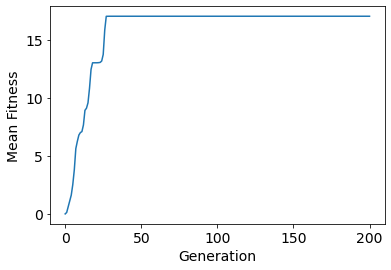

In [ ]:
plt.rc('axes', labelsize=14)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14) 
plt.rc('legend', fontsize=14)

fig1, ax1 = plt.subplots()
line1 = ax1.plot(gen, avgs)
ax1.set_xlabel("Generation")
ax1.set_ylabel("Mean Fitness")

# Best Individual

In [ ]:
indiv = tools.selBest(pop, 1)[0]
print(indiv)

if_danger_up(if_danger_two_down(if_danger_up(if_food_down(if_food_right(if_danger_two_right(move_right, if_food_up(move_right, move_left)), if_food_right(if_food_down(move_left, move_down), if_danger_two_left(move_left, move_right))), if_danger_down(if_danger_two_right(move_left, move_right), move_left)), if_danger_left(if_danger_left(move_right, if_danger_up(if_food_down(move_left, move_right), if_food_left(move_right, move_right))), move_up)), if_food_right(if_food_right(if_danger_two_left(move_down, move_right), if_food_rightwards(move_right, move_left)), if_food_right(if_danger_two_up(move_down, move_down), if_food_downwards(if_danger_two_down(if_danger_down(move_right, move_left), if_danger_left(move_down, move_right)), if_food_rightwards(if_food_left(move_right, move_down), if_danger_two_down(move_down, move_down)))))), if_food_left(if_danger_two_left(if_food_downwards(move_down, if_danger_left(if_food_right(move_right, if_food_rightwards(move_down, move_up)), move_up)), if_food_

In [ ]:
nodes, edges, labels = gp.graph(indiv)

tree = pgv.AGraph()
tree.add_nodes_from(nodes)
tree.add_edges_from(edges)
tree.layout(prog="dot")

for i in nodes:
    n = tree.get_node(i)
    n.attr["label"] = labels[i]

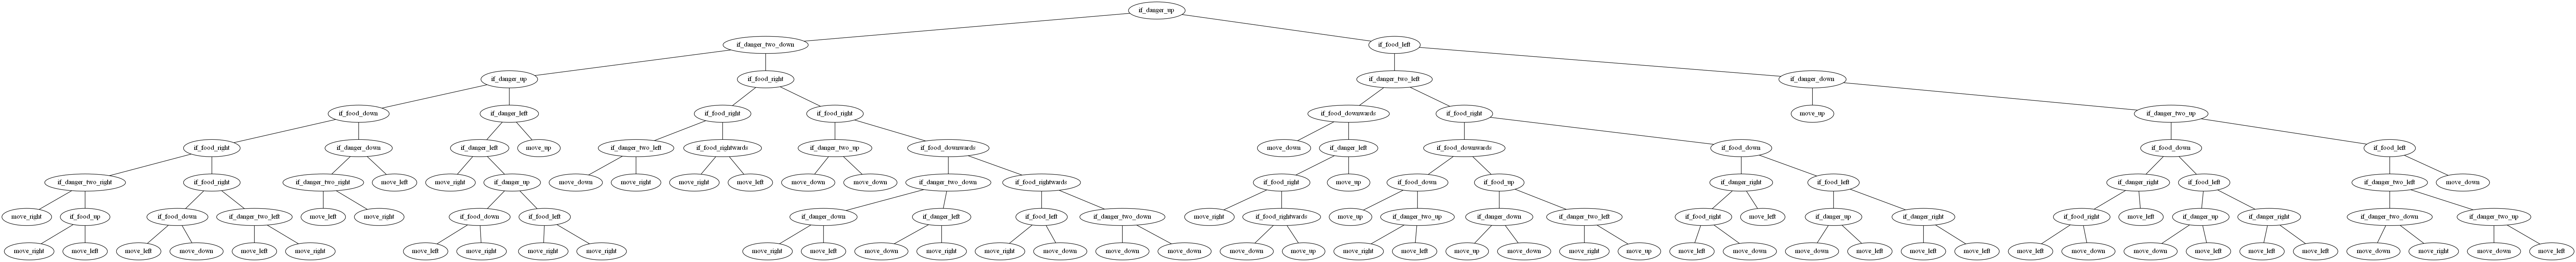

In [ ]:
from IPython.display import Image

treePlot = tree.draw(format='png', prog='dot')
Image(treePlot)

In [ ]:
toolbox.evaluate(indiv)

(1,)

Below is what you would use for your evaluation. You would also use it to display your final (pickled and loaded) solution, with headless = False.

In [ ]:
routine = gp.compile(indiv, pset)

run_game(display, snake_game, routine, headless=HEADLESS)

(8, 910, 500)